In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from project.ranker.ranker import RankingPredictor

In [3]:
%%time
from sklearn.model_selection import train_test_split
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=15)),
])
df_mf, df_rank, df_scores = rp.named_steps['estimator'].get_data()

X, _, y, _, y_scores, _ = train_test_split(df_mf.values,
                                           df_rank.values,
                                           df_scores.values,
                                           test_size=0,
                                           random_state=42)
print(X.shape, y.shape, y_scores.shape)

(60, 39) (60, 13) (60, 13)
CPU times: user 40.6 s, sys: 4.09 s, total: 44.7 s
Wall time: 49.7 s


In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

class RankDataset(Dataset):
    def __init__(self, X_cont, X_cats, y):
        super().__init__()
        self.X_cont = X_cont.astype(np.float32)
        self.X_cats = X_cats.astype(np.int64)
        self.y = y.astype(np.float32) # 0-1
        
        self.mf_sz = X_cont.shape[1]
        self.fs_sz = len(np.unique(X_cats))
        
    def __len__(self):
        return len(self.X_cont)
    
    def __getitem__(self, idx):
        return [self.X_cont[idx], self.X_cats[idx], self.y[idx]]

In [31]:
import torch.nn as nn
from torch import optim
from project.ranker.neural_ranker import RankNet
from scipy.stats import rankdata

class NeuralNetwork():
    def __init__(self, mf_sz, fs_sz, params):
        self.mf_sz, self.fs_sz = mf_sz, fs_sz
        self.latent_sz = params['latent_sz']
        self.epochs = params['epochs']
        self.lr = params['learning_rate']
        
        self.model = RankNet(mf_sz, fs_sz, self.latent_sz)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        
    def train(self, dl):
        train_losses = []
        for epoch in range(self.epochs):
            train_loss = 0
            for X_cont, X_cats, y in dl:
                train_loss += self.train_step(X_cont, X_cats, y)
            train_losses.append(train_loss) 
        return train_losses
    
    def train_step(self, X_cont, X_cats, y):
        self.model.train()
        self.optimizer.zero_grad()
        preds = self.model(X_cont, X_cats)
        loss = self.criterion(preds.view(-1), y)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def predict(self, dl):
        preds = []
        self.model.eval()
        for X_cont, X_cats, y in dl:
            X_cont.requires_grad_(False)
            X_cats.requires_grad_(False)
            
            pred = self.model(X_cont, X_cats).cpu().detach().numpy()
            preds.extend(pred)
        return np.array([rankdata(x, method='ordinal') for x in \
                         np.reshape(preds, (-1, self.fs_sz))]).astype(int)

In [32]:
def wide2long(X, y):
    n_samples, n_classes = y.shape
    X_cont = np.repeat(X, n_classes, axis=0)
    X_cats = np.array(list(range(n_classes)) * n_samples)
    return X_cont, X_cats.astype(int), y.reshape(-1)

In [33]:
from project.utils.metrics import evaluate_metric

def cv_neuralnet(X, y, y_scores, kfolds, params, verbose_folds=False):
    results = []
    models = []
    X = StandardScaler().fit_transform(X)
    y = (y - y.min()) / (y.max() - y.min())
    for idx, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
        X_trn, y_trn, y_scores_trn = X[trn_idx], y[trn_idx], y_scores[trn_idx]
        X_val, y_val, y_scores_val = X[val_idx], y[val_idx], y_scores[val_idx]
        
        X_trn_cont, X_trn_cats, y_trn_long = wide2long(X_trn, y_trn)
        X_val_cont, X_val_cats, y_val_long = wide2long(X_val, y_val)
        
        trn_ds = RankDataset(X_trn_cont, X_trn_cats, y_trn_long)
        val_ds = RankDataset(X_val_cont, X_val_cats, y_val_long)
        
        neuralnet = NeuralNetwork(trn_ds.mf_sz, trn_ds.fs_sz, params)
        trn_dl = DataLoader(trn_ds, batch_size=params['batch_sz'], shuffle=True)
        neuralnet.train(trn_dl)
        
        trn_dl = DataLoader(trn_ds, batch_size=params['batch_sz'], shuffle=False)
        val_dl = DataLoader(val_ds, batch_size=params['batch_sz'], shuffle=False)
        
        y_pred_trn = neuralnet.predict(trn_dl)
        y_pred_val = neuralnet.predict(val_dl)
        
        trn_spearman = evaluate_metric("spearman", y_trn, y_pred_trn)
        trn_acc_loss = evaluate_metric("mean_acc_loss", y_scores_trn, y_pred_trn)
        val_spearman = evaluate_metric("spearman", y_val, y_pred_val)
        val_acc_loss = evaluate_metric("mean_acc_loss", y_scores_val, y_pred_val)
        
        if verbose_folds:
            print(f'Fold {idx + 1:>3} | '
                  f'Trn_Spearman: {trn_spearman: .4f} | '
                  f'Val_Spearman: {val_spearman: .4f} | '
                  f'Trn_ACCLoss: {trn_acc_loss: .4f} | '
                  f'Val_ACCLoss: {val_acc_loss: .4f}')
            
        results.append((trn_spearman, val_spearman, 
                        trn_acc_loss, val_acc_loss))
        models.append(neuralnet)
        
#         break # 1-fold
          
    results = np.array(results)
    print()
    print(f'Trn_Spearman: {results[:,0].mean(): .4f} +/-{results[:,0].std():.4f} | '
          f'Val_Spearman: {results[:,1].mean(): .4f} +/-{results[:,1].std():.4f}\n'
          f'Trn_ACCLoss:  {results[:,2].mean(): .4f} +/-{results[:,2].std():.4f} | '
          f'Val_ACCLoss:  {results[:,3].mean(): .4f} +/-{results[:,3].std():.4f}')
    print()
    return results, models

In [37]:
%%time
import lightgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {
    'latent_sz': 16,
    'learning_rate': 1e-3,
    'batch_sz': 16,
    'epochs': 10,
}
results, models = cv_neuralnet(X, y, y_scores, kfolds, params, 
                               verbose_folds=True)

Fold   1 | Trn_Spearman:  0.4223 | Val_Spearman:  0.1264 | Trn_ACCLoss:  0.0691 | Val_ACCLoss:  0.1900
Fold   2 | Trn_Spearman:  0.4915 | Val_Spearman:  0.1502 | Trn_ACCLoss:  0.0590 | Val_ACCLoss:  0.2154
Fold   3 | Trn_Spearman:  0.4733 | Val_Spearman:  0.0266 | Trn_ACCLoss:  0.0599 | Val_ACCLoss:  0.0603
Fold   4 | Trn_Spearman:  0.4369 | Val_Spearman:  0.1722 | Trn_ACCLoss:  0.0645 | Val_ACCLoss:  0.1413
Fold   5 | Trn_Spearman:  0.4941 | Val_Spearman:  0.2170 | Trn_ACCLoss:  0.0560 | Val_ACCLoss:  0.0392
Fold   6 | Trn_Spearman:  0.5531 | Val_Spearman:  0.2115 | Trn_ACCLoss:  0.0392 | Val_ACCLoss:  0.1747
Fold   7 | Trn_Spearman:  0.4535 | Val_Spearman:  0.1676 | Trn_ACCLoss:  0.0664 | Val_ACCLoss:  0.1963
Fold   8 | Trn_Spearman:  0.5075 | Val_Spearman: -0.0321 | Trn_ACCLoss:  0.0654 | Val_ACCLoss:  0.1205
Fold   9 | Trn_Spearman:  0.3997 | Val_Spearman:  0.4130 | Trn_ACCLoss:  0.0937 | Val_ACCLoss:  0.1112
Fold  10 | Trn_Spearman:  0.5338 | Val_Spearman:  0.0604 | Trn_ACCLoss:  

## 100-fold run

In [24]:
%%time
import lightgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {
    'latent_sz': 16,
    'learning_rate': 1e-3,
    'batch_sz': 16,
    'epochs': 10,
}
results, models = cv_neuralnet(X, y, y_scores, kfolds, params, 
                               verbose_folds=True)

Fold   1 | Trn_Spearman:  0.4781 | Val_Spearman:  0.1447 | Trn_ACCLoss:  0.0452 | Val_ACCLoss:  0.1400
Fold   2 | Trn_Spearman:  0.5380 | Val_Spearman:  0.1419 | Trn_ACCLoss:  0.0283 | Val_ACCLoss:  0.2473
Fold   3 | Trn_Spearman:  0.5638 | Val_Spearman:  0.2344 | Trn_ACCLoss:  0.0590 | Val_ACCLoss:  0.0260
Fold   4 | Trn_Spearman:  0.5198 | Val_Spearman:  0.3910 | Trn_ACCLoss:  0.0617 | Val_ACCLoss:  0.0527
Fold   5 | Trn_Spearman:  0.4663 | Val_Spearman:  0.4295 | Trn_ACCLoss:  0.0678 | Val_ACCLoss:  0.0109
Fold   6 | Trn_Spearman:  0.5526 | Val_Spearman:  0.3471 | Trn_ACCLoss:  0.0448 | Val_ACCLoss:  0.1649
Fold   7 | Trn_Spearman:  0.4754 | Val_Spearman:  0.2509 | Trn_ACCLoss:  0.0617 | Val_ACCLoss:  0.1527
Fold   8 | Trn_Spearman:  0.5280 | Val_Spearman:  0.1648 | Trn_ACCLoss:  0.0542 | Val_ACCLoss:  0.0706
Fold   9 | Trn_Spearman:  0.5307 | Val_Spearman:  0.3324 | Trn_ACCLoss:  0.0487 | Val_ACCLoss:  0.0793
Fold  10 | Trn_Spearman:  0.5605 | Val_Spearman:  0.0476 | Trn_ACCLoss:  

In [25]:
acc = pd.read_csv('results/ACC_scores.csv')
acc['Neural Net'] = results[:,3]

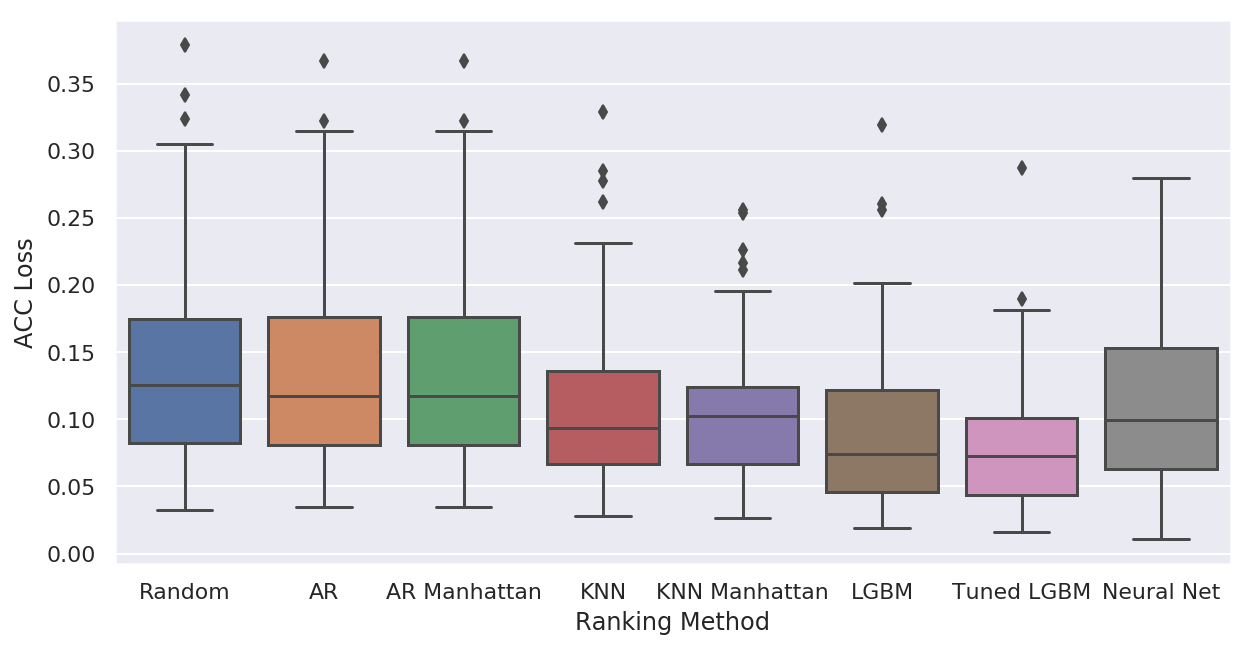

In [27]:
acc = pd.melt(acc, value_vars=['Random', 'AR', 'AR Manhattan', 'KNN', 
                               'KNN Manhattan', 'LGBM', 'Tuned LGBM', 'Neural Net'], 
              var_name='Ranking Method', value_name='ACC Loss')

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='Ranking Method', y='ACC Loss', data=acc)

In [18]:
%%time
import lightgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=2, random_state=42)
params = {
    'latent_sz': 8,
    'learning_rate': 1e-3,
    'batch_sz': 16,
    'epochs': 20,
}
results, models = cv_neuralnet(X, y, y_scores, kfolds, params, 
                               verbose_folds=True)

Fold   1 | Trn_Spearman:  0.4016 | Val_Spearman:  0.2958 | Trn_ACCLoss:  0.0900 | Val_ACCLoss:  0.0475
Fold   2 | Trn_Spearman:  0.4162 | Val_Spearman:  0.1648 | Trn_ACCLoss:  0.0765 | Val_ACCLoss:  0.2200
Fold   3 | Trn_Spearman:  0.4731 | Val_Spearman:  0.0907 | Trn_ACCLoss:  0.0750 | Val_ACCLoss:  0.0506
Fold   4 | Trn_Spearman:  0.2892 | Val_Spearman: -0.0119 | Trn_ACCLoss:  0.1031 | Val_ACCLoss:  0.1721
Fold   5 | Trn_Spearman:  0.2659 | Val_Spearman:  0.2161 | Trn_ACCLoss:  0.1085 | Val_ACCLoss:  0.0388
Fold   6 | Trn_Spearman:  0.3848 | Val_Spearman:  0.1273 | Trn_ACCLoss:  0.0708 | Val_ACCLoss:  0.2507
Fold   7 | Trn_Spearman:  0.3310 | Val_Spearman:  0.1071 | Trn_ACCLoss:  0.0767 | Val_ACCLoss:  0.1254
Fold   8 | Trn_Spearman:  0.3862 | Val_Spearman:  0.0577 | Trn_ACCLoss:  0.0632 | Val_ACCLoss:  0.0901
Fold   9 | Trn_Spearman:  0.3938 | Val_Spearman:  0.3443 | Trn_ACCLoss:  0.0936 | Val_ACCLoss:  0.0600
Fold  10 | Trn_Spearman:  0.3585 | Val_Spearman:  0.1291 | Trn_ACCLoss:  